In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

In [ ]:
train = pd.read_csv('../jupyter_book/data/10k_training_test/cohort_10000_train.csv')
test = pd.read_csv('../jupyter_book/data/10k_training_test/cohort_10000_test.csv')
data = pd.concat([train, test], axis=0)

# Thrombectomy 

### T=0 

Plot the distribution of mRS at time T=0 (i.e. before stroke) from the data.

density=True makes the bars of the histogram add up to 1 - so y-axis shows probability of each mRS.

In [ ]:
fig = plt.figure(figsize=(5,5))

dist_0, _, _ = plt.hist(data['S2RankinBeforeStroke'].values, bins = [0,1,2,3,4,5,6], density=True, width=0.6, align='mid')
# dist_0 = np.cumsum(np.concatenate((dist_0,[0.0])))

plt.show()

In [ ]:
dist_0

Or, to skip loading it from data:

In [4]:
dist_0 = np.array([0.54956819, 0.14895196, 0.0980681 , 0.11769072, 0.06707674, 0.0186443])
# dist_0 = np.cumsum(np.concatenate((dist_0,[0.0])))

Convert the mRS distribution into cumulative frequency:

In [5]:
bins_0 = np.cumsum(np.concatenate(([0],dist_0)))

In [6]:
bins_0

array([0.        , 0.54956819, 0.69852015, 0.79658825, 0.91427897,
       0.98135571, 1.00000001])

### T = 8 hours 

Collect "untreated" mRS distribution, i.e. mRS at time T=8hrs.
_Presumably_ this only includes patients when no thrombolysis or thrombectomy has been performed.

Data from Goyal+2016[1], Figure 1 (A Overall, Control population). mRS=6 is excluded and P(mRS=6)=0.189.

[1] _"Endovascular thrombectomy after large-vessel ischaemic stroke: a meta-analysis of individual patient data from five randomised trials"_

In [7]:
#from golye's control population (figure 1a)

dist_F_ect = [0.05, 0.079, 0.136, 0.164, 0.247, 0.135]

Convert to cumulative frequency:

In [8]:
bins_F_ect = np.cumsum(np.concatenate(([0],dist_F_ect)))

# Need to normalise because it currently doesn't add up to 1 (non-zero mRS=6 is excluded).
bins_F_ect = bins_F_ect/bins_F_ect[-1]

bins_F_ect

array([0.        , 0.06165228, 0.15906289, 0.32675709, 0.52897657,
       0.83353884, 1.        ])

Test some probability "x" - which mRS bin does it fall into?

In [9]:
#x = np.random.rand()
x = 0.5

np.digitize(x, bins_F_ect, right=True)-1

3

## Workings 

From Allen.pdf pseudocode paper §2.4.1:

$$log Odds ratio = 0.746 - 0.12T$$

T = hours from onset to treatment

odds ratio = odds of outcome if exposed / odds of outcome if not exposed


Define:

- $m$ : value of mRS
- $T$ : hours from onset to treatment
- $T_0$ : time of zero effect
- $O(m, x, T)$ : odds ratio for mRS <= x if thrombolysis given at time T
- $N(\cdot)$ : number of patients satisfying condition $\cdot$
- $P(\cdot)$ : probability of patient satisfying condition $\cdot$


Also, inequalities $\leq$ are used to give the cumulative probabilities.

By definition, odds ratio:

1 : $$ O(m,x,T) = \frac{N(m\leq x|T)/N(m>x|T)}{N(m\leq x|T_0)/N(m>x|T_0)} $$

i.e.:

2 : $$\log(O(m,x,T)) = \log(N(m\leq x|T)) - \log(N(m>x|T)) - \log(N(m\leq x|T_0)) + \log(N(m>x|T_0)) $$ 

3 : $$\log(O(m,x,T)) = \log(P(m\leq x|T)) - \log(P(m>x|T)) - \log(P(m\leq x|T_0)) + \log(P(m>x|T_0)) $$ 


### Find formula for odds (in terms of _a_ and _b_):

Assume linear realtionship between log odds and time holds for all values of m, for each value of m we solve:

4 : $$ \log(O(m,x,T)) = a + bT $$
 

Equating 3 and 4:

5 : $$ a + bT = \log(P(m\leq x|T)) - \log(P(m>x|T)) - \log(P(m\leq x|T_0)) + \log(P(m>x|T_0))$$

This will be used to calculate the odds, i.e. we need to find _a_ and _b_. All of the log(_P_) are known from the input data. 


### Find formula for probability (in terms of _A_ and _b_):

Absorbing terms depending on $T_0$ on RHS into constant on LHS:

6: $$ A + bT = \log(P(m\leq x|T)) - \log(P(m>x|T)) $$

$$ A + bT = \log(P(m\leq x|T)) - \log(1 - P(m\leq x|T))$$

$$ A + bT = \log(\frac{P(m\leq x|T)}{1 - P(m\leq x|T)})$$

$$e^{A + bT} = \frac{P(m\leq x|T)}{1 - P(m\leq x|T)}$$

This equation is still just odds, but in terms of _A_ and _b_.


Solve for probability $P \equiv P(m\leq x|T)$: 

$$e^{A + bT}(1-P) = P$$

$$e^{A + bT} = (1+e^{A + bT})P$$

$$ \frac{e^{A + bT}}{1+e^{A + bT}} = P $$

So _A_ and _b_ are needed to calculate probability _P_. 

## Model 1

Assume log odds = 0 at $T_0$.

Each mRS has different values of _a_, _b_, and _A_, and so the variables `a`, `b`, and `A` are arrays - index 0 for mRS=0 values etc.

### Find a

At T = 0, log odds = a (see Equation 4). Find the value of _a_ by using Equation 5 above:

$$ a = \log(P(m\leq x|T=0hr)) - \log(P(m>x|T=0hr)) - \log(P(m\leq x|T_0)) + \log(P(m>x|T_0))$$

All of the following probabilities are known from the input data:

- $P(m\leq x|T=0hr)$ = `np.cumsum(dist_0)[:-1]`

- $P(m>x|T=0hr)$ = `1 - np.cumsum(dist_0)[:-1]`

- $P(m\leq x|T=T_0)$ = `F_ect[:-1]`

- $P(m>x|T=T_0)$ = `1 - F_ect[:-1]`

The probabilities are not calculated using the `bins_0` and `bins_F_ect` defined earlier as those arrays contain an extra 0.0 at the beginning, and we don't want to set mRS=0 to probabilities 0.0.

mRS<=5 is excluded from the calculations because P(mRS<=5)=1.0 at all times, and so values for _a_, _b_ and _A_ cannot be found. Instead a straight horizontal line is plotted to show mRS<=5.

In [10]:
F_ect = np.cumsum(dist_F_ect)

F_ect = F_ect/F_ect[-1]

print(F_ect)

p1_ect = np.log(np.cumsum(dist_0)[:-1])
p2_ect = np.log(1 - np.cumsum(dist_0)[:-1])
p3_ect = np.log(F_ect[:-1])
p4_ect = np.log(1 - F_ect[:-1])

a_ect = p1_ect-p2_ect - p3_ect+p4_ect

print(a_ect)

[0.06165228 0.15906289 0.32675709 0.52897657 0.83353884 1.        ]
[2.92153651 2.5054781  2.08799482 2.25100125 2.35247676]


### Find b 

At T = 8hr (i.e. $T=T_0$), log odds = 0 because the RHS of Equation 5 above cancels to zero.

$$ b = -\frac{a}{8} $$

In [11]:
b_ect = -a_ect/(8*60)

### Find A 

_A_ combines _a_ and all of the $T_0$ terms - see the difference between Equations 5 and 6 above.  


$$ A = a + \log(P(m\leq x|T_0)) - \log(P(m>x|T_0))$$

In [12]:
A_ect = a_ect+p3_ect-p4_ect

### Plot log odds as function of time

Each mRS value has a different _a_ and _b_ to calculate its log-odds. 

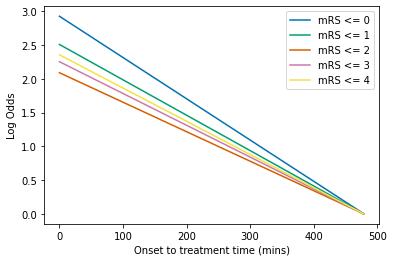

In [13]:
t = np.arange(0,8*60)

for i,a_i in enumerate(a_ect):
    
    plt.plot(t, a_i + b_ect[i]*t, '-', label = f'mRS <= {i}')
    
plt.legend(loc='best')

plt.ylabel('Log Odds')

plt.xlabel('Onset to treatment time (mins)')

plt.show()

### Plot P as function of time 

Each mRS value has a different _A_ and _b_ to calculate its probability with time.

Because all of the calculations so far have used cumulative probability $P(m\leq x|T)$, the lines should be viewed as being stacked on top of each other. 

We started with the data at t=0 and t=$T_0$ and have calculated the lines in between.

Basic plot:

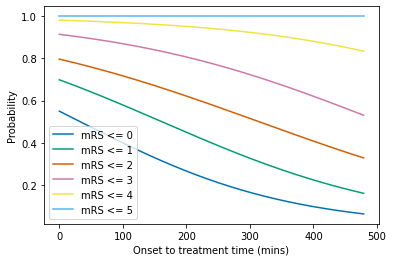

In [14]:
t = np.arange(0,8*60)

for i,A_i in enumerate(A_ect):
    
    plt.plot(t, np.exp(A_i + b_ect[i]*t)/(1+np.exp(A_i + b_ect[i]*t)), '-', label = f'mRS <= {i}')
    
plt.plot(t, [1.0 for x in t], '-', label = 'mRS <= 5')

plt.ylabel('Probability')

plt.xlabel('Onset to treatment time (mins)')

plt.legend(loc='best')

plt.show()

The same lines plotted with extra annotations:

In [15]:
def plot_probs(A_ect,b_ect,t,bins_0,bins_F,colour_bins=1,mark_data_ect=0,mark_data_oly=0,plot_mRS5=1):
    """
    Plot cumulative probability against time with fancier labelling.
    
    Inputs:
    A_ect         - list or np.array. Contains values of A for P(t,A,b).
    b_ect         - list or np.array. Contains values of b for P(t,A,b).
    t             - list or np.array. Time steps.
    bins_0        - list or np.array. Cumulative probability bins at t=0.
    bins_F        - list or np.array. Cumulative probability bins at t=T_0.
    colour_bins   - int, 0 or 1. Whether to colour the gaps between P(t) lines.
    mark_data_ect - int, 0 or 1. Whether to mark the input data for thrombectomy.
    mark_data_oly - int, 0 or 1. Whether to mark the input data for thrombolysis.
    plot_mRS5     - int, 0 or 1. Whether to draw P(mRS<=5) along the top.
    
    """
    if plot_mRS5>0:
        # P(mRS<=5)=1.0 at all times, so we cannot define A, a, and b.
        # Instead append to this array a 0.0, which won't be used directly
        # but will allow the "for" loop to go round one extra time.
        A_ect = np.append(A_ect,0.0)
    for i,A_i in enumerate(A_ect):

        # Define the probability line, p_i:
        if i<5:
            p_i = np.exp(A_i + b_ect[i]*t)/(1+np.exp(A_i + b_ect[i]*t))
        else:
            # P(mRS<=5)=1.0 at all times:
            p_i = np.full(t.shape,1.0)
        # Plot it as before and store the colour used:
        l, = plt.plot(t, p_i, '-', label = f'mRS <= {i}')
        colour = l.get_color()

        if mark_data_ect>0:
            # Mark the thrombectomy data at time t=0hr and t=T_0.
            # If first marker plotted, then add a label for the legend:
            l_t0 = 'SAMueL data'     if i<1 else None
            l_tF = 'Goyal+2016 data' if i<1 else None
            # (Keep i+1 index because the first value in bins_0 is just 0.0):
            plt.scatter(0, bins_0[i+1],
                        marker='o', label=l_t0, facecolor=colour, edgecolor='k')
            plt.scatter(8*60, bins_F[i+1],
                        marker='s', label=l_tF, facecolor=colour, edgecolor='k')
            
        if mark_data_oly>0:
            # Mark the thrombolysis data. 
            if i==1:
                # For mRS<=1 only, plot the reference data point.
                ti = np.where(t==1.0*60)
                plt.scatter(t[ti], p_i[ti],
                            marker='D', label='Emberson+2014 data', 
                            facecolor=colour, edgecolor='k')
                
            # Mark the data at time t=6.3hr.
            # If this is the first marker plotted, then add a label for the legend:
            l_tF = 'Lees+2010 data' if i<1 else None
            # (Keep i+1 index because the first value in bins_0 is just 0.0):
            plt.scatter(6.3*60, bins_F[i+1],
                        marker='X', label=l_tF, facecolor=colour, edgecolor='k')
              
        if colour_bins>0:

            # Fill in the area between this line, p_i, and the line below, p_j.
            # This area marks where mRS <= the given value.
            # If p_j is not defined yet (i=0), set all p_j to zero:
            p_j = p_j if i>0 else np.zeros_like(p_i)
            plt.fill_between(t, p_i, p_j, color=colour, alpha=0.3)#, label=f'mRS = {i}')
            # ^ alpha is just used as a quick way to lighten the fill colour.

            # Store the most recently-created line for the next loop:
            p_j = p_i
    
    
    plt.legend(loc='center left', bbox_to_anchor=[1.0,0.5,0.2,0.2])

    plt.ylabel('Probability')

    plt.xlabel('Onset to treatment time (mins)')

    plt.ylim(-0.02,1.02)

Fancier plot:

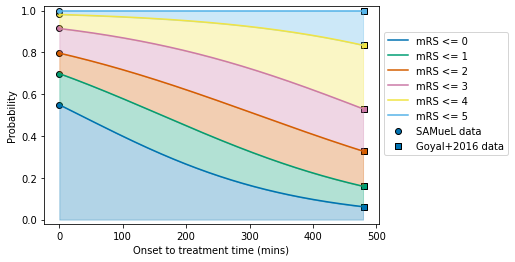

In [16]:
t = np.arange(0,8*60)

plot_probs(A_ect,b_ect,t,bins_0,bins_F_ect,colour_bins=1,mark_data_ect=1)

plt.show()

### Plot treated 'intervention' population:

Add in Goyal+2016 Figure 1B treated 'intervention' population:

In [17]:
# Probabilities for the treated 'intervention' population:
p_treated = np.array([0.100, 0.169, 0.191, 0.169, 0.156, 0.062])#, 0.153])

# Margin of error calculation:
z = 1.96
n = 633
errs = []

# Print the n*p and n*(1-p) values to check they are above 10.0,
# else this error method is invalid.
for i,p in enumerate(p_treated):
    err = p * z * np.sqrt(p*(1.0-p)/n)    
    errs.append(p*err)

    if n*p<10.0 or n*(1-p)<10.0:
        # Print the n*p and n*(1-p) values to check they are above 10.0,
        # else this error method is invalid.
        print('mRS \t n*p \t n*(1-p)')
        print(i, '\t', round(n*p,1), '\t', round(n*(1-p),1))
    
# Cumulative probability of treated population:    
cp_t = np.cumsum(p_treated)
# Normalise because excluding mRS=6:
cp_t = cp_t/cp_t[-1]

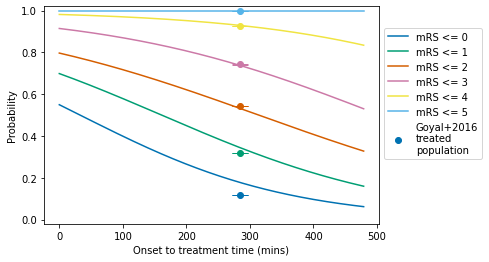

In [18]:
t = np.arange(0,8*60)


for i,p in enumerate(cp_t):
    # Scatter the Goyal+2016 Figure 1B treated 'intervention' population:
    cpt_lab = 'Goyal+2016\ntreated\npopulation' if i==0 else None
    s = plt.scatter(285, p, label=cpt_lab)
    # y-errorbar calculated in previous cell.
    # x-errorbar from paper, Table 1 "onset to reperfusion".
    plt.errorbar(285,p,
                 yerr=errs[i], 
                 # xerr=np.array([[285-210],[362-285]]), 
                 color=s.get_facecolors(), capsize=8)

# Plot lines as before:
plot_probs(A_ect,b_ect,t,bins_0,bins_F_ect,colour_bins=0,mark_data_ect=0)

plt.show()

# # Use tight_layout() to make sure the legend isn't cut off when image is saved:
# plt.tight_layout()
# plt.savefig('thromb_goyal-treated-population_v2.pdf')
# plt.close()

## Model 1 code

Inputs: 

- Time to thrombectomy or thrombolysis
- Time to zero effect (set at 8 hours, but optionally changed)

Outpts:

- Single sample of mRS if untreated, and mRS if treated
- 100 samples of mRS if untreated, and mRS if treated, and probability of mRS being improved by at least 1

In [19]:
def stroke_outcome(dist_0, dist_F, treatment_time, time_zero_effect=8*60, single=True, n_iter=100, xs=[]):
    
    '''
    Inputs
    
    dist_0:           1D list or numpy array. Element i corresponds to 
                      the proportion of patients that had mRS=i, before stroke or 
                      if treated at time t=0.
    dist_F:           1D list or numpy array. Element i corresponds to 
                      the proportion of patients that had mRS=i if not treated
                      or treated after time_zero_effect
    treatment_time:   int. time in minutes between stroke and treatment    
    time_zero_effect: int. time in minutes after stroke that treatment
                      has no effect.                      
    single:           bool. If True, model will only perform one iteration    
    n_iter:           int. If single=False, number of iterations the model 
                      will perform.
    xs:               1D list or numpy array. List of values of 'x' to try.
                      
    
    Outputs
    
    mRS_0:  1D list. mRS if treated at time t=0     
    mRS_F:  1D list. mRS if treated at time_zero_effect  
    mRS_T:  1D list. mRS if treated at treatment_time
    bins_t: bins at treatment_time
    
    '''

    # find a
    F = np.cumsum(dist_F)
    F = F/F[-1]

    p1 = np.log(np.cumsum(dist_0)[:-1])
    p2 = np.log(1- np.cumsum(dist_0)[:-1])
    p3 = np.log(F[:-1])
    p4 = np.log(1-F[:-1])

    a = p1-p2 - p3 + p4

    # find b
    b = -a/(time_zero_effect)

    # find A
    A = a+p3-p4

    # mRS at t=0
    # Get all mRS bins at t=0:
    bins_0 = np.cumsum(np.concatenate(([0],dist_0)))


    # mRS untreated
    # Find which bin 'x' lies in at t=T_0.
    bins_F = np.cumsum(np.concatenate(([0],dist_F)))
    bins_F = bins_F/bins_F[-1]
    #print(bins_F)
    

    # mRS treated
    # Create the probability bins at treatment_time:
    bins_T = [np.exp(A_i + b[i]*treatment_time)/(1+np.exp(A_i + b[i]*treatment_time))\
                 for i,A_i in enumerate(A)]
    # Find which bin 'x' lies in at t=treatment_time.
    bins_T = np.concatenate((np.concatenate(([0],bins_T)),[1]))
    

    
    if single:
        
        n_iter = 1
    elif len(xs)>0:
        n_iter = len(xs)
        
    count=0
    
    mRS_0, mRS_F, mRS_T = [],[],[]
    
    while count<n_iter:
    
        # random number to represent mRS at t=0.
        # x is a probability on the y-axis and so runs from 0 to 1.

        x = np.random.rand() if len(xs)<1 else xs[count]
        #x = 0.9

        # Find which bin 'x' lies in,
        # i.e. which plotted probability line it lies under,
        # at time t=0, t=treatment_time, and t=T_0.
        mRS_0.append(np.digitize(x, bins_0, right=True)-1)
        mRS_F.append(np.digitize(x, bins_F, right=True)-1)
        mRS_T.append(np.digitize(x, bins_T, right=True)-1)
    
        if single:
            
            #print(x)

            print(f'mRS pre-stroke: {mRS_0[-1]}')
            print(f'mRS if not treated: {mRS_F[-1]}')
            print(f'mRS if treated at time={treatment_time}: {mRS_T[-1]}')
            
        count+=1

        
    if not single:
        # For all of the patients (n_iter values of 'x'), record whether 
        # their mRS improved (mRS_T, with treatment at treatment_time) compared with
        # their untreated mRS level (in mRS_F). If improved, set to 1, else set to 0.
        # Then take the average of the 1s and 0s across all n_iter patients. 
        treatment_effect = np.mean([1 if mRS_F[i] - T >=1 else 0 for i,T in enumerate(mRS_T)])
        
        print(f'Probability of mRS improving by 1 or more: {treatment_effect}')
        
    
    return mRS_0, mRS_F, mRS_T, bins_T

In [20]:
# treatment_time = np.random.randint(0, 8*60)
# Manually set treatment time and x:
treatment_time = 210
x = 0.75

print(treatment_time)

mRS_0, mRS_F, mRS_T, bins_T = stroke_outcome(dist_0, dist_F_ect, treatment_time, time_zero_effect=8*60, xs=[x])

210
mRS pre-stroke: 2
mRS if not treated: 4
mRS if treated at time=210: 3


Plot the three mRS values printed above: 

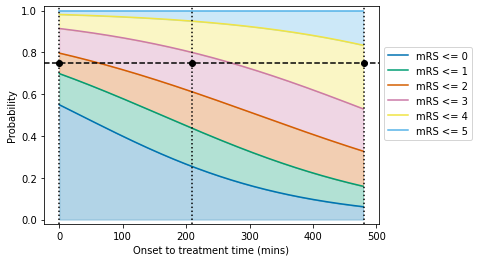

In [21]:
t = np.arange(0,8*60)

# Similar plot to before:
plot_probs(A_ect,b_ect,t,bins_0,bins_F_ect,colour_bins=1,mark_data_ect=0)

# Vertical lines at t=0, treatment time, and t=T_0:
for t in [0,treatment_time,8*60]:
    plt.axvline(t, color='k', linestyle=':')
    
# Horizontal line where considered 'x' is:
plt.axhline(x, color='k', linestyle='--')
    
# Add scatter markers where the horizontal and vertical lines meet:
for t in [0,treatment_time,8*60]:
    plt.scatter(t,x,color='k',marker='o')
    
    
plt.show()

# # Use tight_layout() to make sure the legend isn't cut off when image is saved:
#plt.tight_layout()
#plt.savefig('lines_prob-mRS_time.pdf')
#plt.close()

### For a given start mRS, find the probability of each mRS at a time _t_

In [22]:
# Setup parameters:
treatment_time = np.random.randint(0, 8*60) # 100
print('Treatment time (mins): ', treatment_time)

   
# Generate probabilities xs that give a t=0 mRS of m_start.
m_start = 1 
xmin = bins_0[m_start]
xmax = bins_0[m_start+1]

Treatment time (mins):  241


Use this function to find the probability of each mRS at a given time:

In [23]:
def prob_mRS_in_xrange(bins,xmin,xmax,m_start='?',time='???'):
    """
    Given some range in cumulative probability, find the probability of being
    in each mRS bin at a given time t. 
    
    Inputs:
    bins    - List or np.array. List of cumulative probabilities of each mRS 
              at a given time t. 
    xmin    - Float. Minimum P(mRS<=x|t) to check.
    xmax    - Float. Maximum P(mRS<=x|t) to check
    m_start - String. Used for printing only, the mRS at t=0.
    time    - String. Used for printing only, the value of t.
    
    Returns:
    -
    """
    # Find intersections of the probability lines with the vertical t line
    # within the specified range of x:
    m_int = np.where( (bins<xmax) & (bins>xmin) )[0]
    if len(m_int)>0:
        # Find the probability of each m:
        p_int = bins[m_int]
        
        # Include the boundary values at xmin, xmax:
        m_ints = [m_int[0]-1, *m_int, m_int[-1]+1]
        p_ints = [xmin, *p_int, xmax]
        
        # Store probabilities here:
        pm_list = []
        for i in range(len(m_ints)-1):
            # Find the proportion of the probability range (y-axis span)
            # that is covered by this value of mRS.
            pmin = p_ints[i]
            pmax = p_ints[i+1]
            p_m = (pmax-pmin)/(xmax-xmin)
            print('P(mRS={mRS:1} | m_start={m_start:1s}, t={time:3s}): {P:1.4f}'.format(
                mRS=m_ints[i], m_start=str(m_start), time=str(time), P=p_m))
            pm_list.append(p_m)
        print('Sanity check: sum of probs', np.sum(pm_list))
    else:
        # If there are no intersections in the chosen x range,
        # find the fixed value of mRS in this range.
        try:
            m_int = np.where(bins>=xmax)[0][0]-1
        except:
            # m>4 isn't included in the input data.
            m_int = 5
        print('P(mRS={mRS:1} | m_start={m_start:1s}, t={time:3s}): {P:1.4f}'.format(
            mRS=m_int, m_start=str(m_start), time=str(time), P=1.0))

Plot the considered mRS as a probability range on the y-axis:

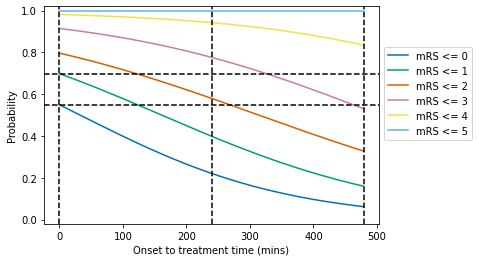

m_start: 1

Time = 0
P(mRS=1 | m_start=1, t=0  ): 1.0000

Time = 241
P(mRS=2 | m_start=1, t=241): 0.1945
P(mRS=3 | m_start=1, t=241): 0.8055
Sanity check: sum of probs 1.0

Time = 480
P(mRS=4 | m_start=1, t=480): 1.0000


In [24]:
# Calculate the mRS bins at treatment_time:
bins_T_ect = [np.exp(A_i + b_ect[i]*treatment_time)/(1+np.exp(A_i + b_ect[i]*treatment_time))\
             for i,A_i in enumerate(A_ect)]
bins_T_ect = np.concatenate((np.concatenate(([0],bins_T_ect)),[1]))

# Draw covered range:
t = np.arange(0,8*60)
# Similar plot to before:
plot_probs(A_ect,b_ect,t,bins_0,bins_F_ect,colour_bins=0,mark_data_ect=0)


# New bits:
# Vertical line at t=0, treatment time, and t=T_0:
for t in [0,treatment_time,8*60]:
    plt.axvline(t, color='k', linestyle='--')
# Horizontal lines where considered 'x' are:
for x in [xmin,xmax]:
    plt.axhline(x, color='k', linestyle='--')
    
plt.show()


# Use this function to find the probability of each mRS at a given time:
print('m_start:', m_start)
# Check probability of each mRS at t=0, t=T, and t=T_0:
print('\nTime =', 0)
prob_mRS_in_xrange(bins_0,xmin,xmax, m_start, 0)

print('\nTime =', treatment_time)
prob_mRS_in_xrange(bins_T_ect,xmin,xmax, m_start, treatment_time)

print('\nTime =', 8*60)
prob_mRS_in_xrange(bins_F_ect,xmin,xmax, m_start, 8*60)

### Incorporate uncertainties into the previous plot:

(not sure it's possible with the available data)

---

# Thrombolysis 

Same models, but different `dist_0` and `dist_F`.

## T=6.3hrs untreated population

These values are read off Lees+2010 Figure 2 by measuring the widths of the boxes in Powerpoint. 
These measurements are somewhat imprecise so these arrays don't have an integer number of patients in any category, but the categories do sum to the required quantity of patients.

The four bars cover different time ranges, respectively 0-90min, 91-180min, 181-270min, 271-360min. 
These bars have different numbers of patients, respectively 151, 315, 811, 543.
All four bars contain data on mRS=0,...,6 inclusive.

In [25]:
# Untreated population. Four sets of numbers of patients with mRS 0,1,...,5,6:
n_0 = np.array([ 15.91421569,  30.34803922,  16.46936275,  18.38153595,  29.05269608,  10.60947712,  30.2246732 ])
n_1 = np.array([ 46.06617647,  45.42279412,  29.85294118,  51.72794118,  61.12132353,  33.84191176,  46.96691176])
n_2 = np.array([129.53472222, 176.90931373, 108.66339869, 113.96405229, 134.50408497,  64.60171569,  82.82271242])
n_3 = np.array([ 78.96568627, 115.34313725,  72.97671569,  70.09313725, 104.03063725,  47.68995098,  53.90073529])

# Combine the four datasets and create probability distribution:
n_F_oly = np.sum([n_0,n_1,n_2,n_3],axis=0)
# Remove mRS=6 with [:-1]:
dist_F_oly = n_F_oly[:-1] / np.sum(n_F_oly[:-1])

# Create cumulative probability:
bins_F_oly = np.cumsum(np.concatenate(([0.0],dist_F_oly)))

In [26]:
dist_F_oly

array([0.16841002, 0.2291431 , 0.14193671, 0.15825232, 0.2046646 ,
       0.09759325])

In [27]:
bins_F_oly

array([0.        , 0.16841002, 0.39755312, 0.53948983, 0.69774214,
       0.90240675, 1.        ])

## T=0hrs population

The existing dist_0 from the SAMueL data will be scaled according to the known value from Emberson et al. 2014 [2], odds ratio for mRS <=1 at t=1hr is $\sim 1.9$.

[2] _"Effect of treatment delay, age, and stroke severity on the effects of intravenous thrombolysis with alteplase for acute ischaemic stroke: a meta-analysis of individual patient data from randomised trials"_

- `bins_0` - bins at $t=0hr$ (from SAMueL data).
- `bins_0_oly` - bins at t=0 for thrombolysis, scaled from `bins_0` using OR=1.9 for mRS<=1 at t=1hr.
- `bins_F_oly` - bins at $t=T_0=6.3hr$, the thrombolysis non-effect time.

By definition, odds ratio:

$$O = \frac{p_1/(1-p_1)}{p_2/(1-p_2)}$$

Log-odds is a straight line, $log(O) = a + bT$. At $T=1hr$, $O=e^{a}$. Then from the above,

$$ \frac{e^{a}p_2}{1-p_2} = \frac{p_1}{1-p_1}$$

We define these two probabilities:

$$p_1 = P(m\leq1|0)$$

$$p_2 = P(m\leq1|T_0)$$

where $p_1 = $ `bins_0_oly[1]` and $p_2 = $`bins_F_oly[1]`. This `bins_0_oly` and corresponding distribution `dist_0_oly` are calculated in `get_dist_0()`.

This time, to solve for _a_, start with usual log-odds straight line assumption:

$$ \log(O) = a + bT $$

At time $T=T_0$, $log(O)=0$ and so $b=-\frac{a}{T_0}$.

$$ \log(O) = a -\frac{a}{T_0}T $$

Set $T=1$ because our `OR` variable is defined at that time. Then


$$ a(1 - \frac{1}{T_0}) = \log(O) $$

$$ a = \frac{\log(O)}{1 - \frac{1}{T_0}} $$

In [28]:
def get_dist_0(dist_F,dist_0,OR, T_0 = 6.3*60):
    """
    Find the t=0 distribution of probabilities for thrombolysis.
    
    The dist is found by scaling the known mRS<=1 odds ratio OR at t=1hr 
    to find the t=0hr equivalent. Then the t=0hr value is used to 
    scale the thrombectomy t=0 values to match. 
    
    Inputs:
    dist_F     - list or np.array. Prob. dist at t=T_0
    dist_0     - list or np.array. Prob. dist at t=0
    OR         - float. Odds ratio for scaling.
    T_0        - float. Treatment non-effect time. 
    
    Returns:
    dist_0_oly - np.array. Prob. dist for thrombolysis at t=0.
    bins_0_oly - np.array. Cumulative prob. dist for thrombolysis at t=0.
    """
    
    # OR = odds ratio for mRS <= 1
    
    # set log odds = 0 at 6.3 hours to find gradient
    
    # solve for a (see maths cell) :
    # a = np.log(OR) - b: 
    # a = -T_0b
    a = np.log(OR)/(1 - 1/T_0)
    
    # Find b (see maths cell)
    b = -a/T_0
    
    # p2 from distribution if not treated
    bins_F = np.cumsum(dist_F)

    bins_F = bins_F/bins_F[-1]
    
    p2 = bins_F[1]
    
    # p1 = probability mRS <=1 at t=0
    # From odds ratio (see maths cell):
    lhs = np.exp(a)*p2/(1-p2)
    
    p1 = lhs/(1+lhs)
    
    # scale bins at t=0 around p1
    
    bins_0 = np.cumsum(dist_0)
    
    bins_0_oly = np.zeros_like(bins_0)
    
    
    # See plots later in this notebook to better explain this "for" loop.
    # Here t=0 thrombectomy means the SAMueL-1 dataset. 
    # At this point, we know the probabilities for mRS<=1 at t=0 for both thrombolysis
    # and thrombectomy. The other mRS!=1 probs should be scaled about these points in 
    # the same ratios for thrombectomy as for thrombolysis.
    #     
    # Basically, at t=0, if the gap A between the mRS=n and mRS=1 lines for thrombectomy
    # is X% of the gap B between 0 (n<1) or 1 (n>1) and the mRS=1 line for thrombectomy,
    # then for thrombolysis the equivalent gap A1 should take up X% of the gap B1.
    for mRS in range(6):
    
        if mRS<2:
            # Scale the bins that lie below the known data point.
            # When mRS=1, bins_0_oly[1] = p1.
            bins_0_oly[mRS] = p1*(bins_0[mRS]/bins_0[1])

        else:
            # Scale the bins that lie above the known data point.
            # The p1+ adds a y-offset from zero. 
            bins_0_oly[mRS] =  p1 + (1-p1)*(bins_0[mRS]-bins_0[1])/(1-bins_0[1])
    
    # use bins to obtain distribution
        
    bins_0_oly = np.concatenate(([0],bins_0_oly))

    dist_0_oly = np.diff(bins_0_oly)
    
    return dist_0_oly, bins_0_oly

Find the distributions and bins at time t=0hrs for thrombolysis:

In [29]:
dist_0_oly,bins_0_oly = get_dist_0(dist_F_oly,dist_0,1.9)

In [30]:
dist_0_oly

array([0.4380102 , 0.11871589, 0.14419216, 0.17304382, 0.09862473,
       0.02741321])

In [31]:
bins_0_oly

array([0.        , 0.4380102 , 0.55672609, 0.70091825, 0.87396207,
       0.9725868 , 1.00000001])

## Model 1

Assume log odds = 0 at $T_0$. Then _a_, _b_, and _A_ are calculated in the same way as for thrombectomy.

### Find a

At T = 0, log odds = a

In [32]:
F_oly = np.cumsum(dist_F_oly)

F_oly = F_oly/F_oly[-1]

print(F_oly)

p1_oly = np.log(np.cumsum(dist_0_oly)[:-1])
p2_oly = np.log(1 - np.cumsum(dist_0_oly)[:-1])
p3_oly = np.log(F_oly[:-1])
p4_oly = np.log(1 - F_oly[:-1])

a_oly = p1_oly-p2_oly - p3_oly+p4_oly

[0.16841002 0.39755312 0.53948983 0.69774214 0.90240675 1.        ]


In [33]:
a_oly

array([1.3476964 , 0.64355642, 0.69338531, 1.09988495, 1.34467768])

### Find b 

At T = 6.3, log odds = 0

In [34]:
b_oly = -a_oly/(6.3*60)

### Find A 

In [35]:
A_oly = a_oly+p3_oly-p4_oly

### Plot log odds as function of time

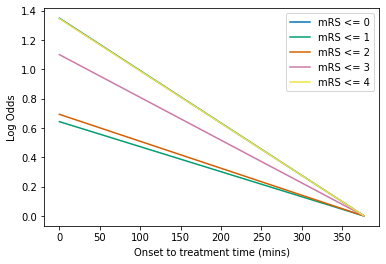

In [36]:
t = np.arange(0,6.3*60)

for i,a_i in enumerate(a_oly):
    
    plt.plot(t, a_i + b_oly[i]*t, '-', label = f'mRS <= {i}')
    
plt.legend(loc='best')

plt.ylabel('Log Odds')

plt.xlabel('Onset to treatment time (mins)')

plt.show()

### Plot P as function of time 

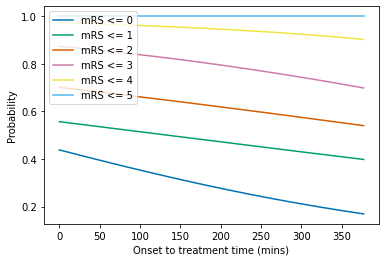

In [37]:
t = np.arange(0,6.3*60)

for i,A_i in enumerate(A_oly):
    
    plt.plot(t, np.exp(A_i + b_oly[i]*t)/(1+np.exp(A_i + b_oly[i]*t)), '-', label = f'mRS <= {i}')

plt.plot(t, [1.0 for x in t], '-', label = 'mRS <= 5')
    
plt.legend(loc='upper left')

plt.ylabel('Probability')

plt.xlabel('Onset to treatment time (mins)')

plt.show()

### Include treated population 
From Lees+2020. As for the $t=T_0$ case, these values are measured from the image using a ruler on Powerpoint and so the number of patients are not integers. The probabilities will be close enough. 

In [38]:
# Treated population (Lees+2010):
# Numbers of patients in the four bars: 161, 303, 809, 576.
n_0 = np.array([ 36.10661765,  31.10825163,  12.89052288,  21.44035948,  21.76919935,   6.77410131,  30.91094771])
n_1 = np.array([ 52.23284314,  74.01715686,  22.27941176,  40.10294118,  35.77083333,  25.12622549,  53.47058824])
n_2 = np.array([190.68341503, 171.84640523, 105.75163399,  83.94035948,  95.17647059,  73.69566993,  87.90604575])
n_3 = np.array([103.29411765, 113.17647059,  67.76470588,  64.94117647,  85.88235294,  56.,          84.94117647])


# # Combine the four datasets and create probability distribution:
# n_t_oly = np.sum([n_0,n_1,n_2,n_3],axis=0)
# # Remove mRS=6 with [:-1]:
# dist_t_oly = n_t_oly[:-1] / np.sum(n_t_oly[:-1])

# # Create cumulative probability:
# bins_t_oly = np.cumsum(np.concatenate(([0.0],dist_t_oly)))

Calculate margin of error associated with the data:

In [39]:
# Number of patients from above:
ns = [n_0,n_1,n_2,n_3]
# Average treatment time for each population:
nts = [45.0,135.0,225.0,315]
# Store binned prob dists and errors in these lists:
bns = []
ens = []

for j,n in enumerate(ns):
    # Convert number distribution to probability:
    # Remove mRS=6 with [:-1]:
    d_n = n[:-1] / np.sum(n[:-1])
    
    
    # Margin of error calculation:
    z = 1.96
    n = np.sum(n[:-1])
    errs = []
    for i,p in enumerate(d_n):
        err = p * z * np.sqrt(p*(1.0-p)/n)
        errs.append(p*err)
        if n*p<10.0 or n*(1-p)<10.0:
            # Print the n*p and n*(1-p) values to check they are above 10.0,
            # else this error method is invalid.
            print('time \t mRS \t n*p \t n*(1-p)')
            print(nts[j], '\t', i, '\t', round(n*p,1), '\t', round(n*(1-p),1))
    ens.append(errs)

    # Create cumulative probability:
    b_n = np.cumsum(d_n)
    bns.append(b_n)

# Transpose for easier plotting:
bns = np.transpose(np.array(bns))
ens = np.transpose(np.array(ens))

time 	 mRS 	 n*p 	 n*(1-p)
45.0 	 5 	 6.8 	 123.3


Plot data as scatter with errorbars:

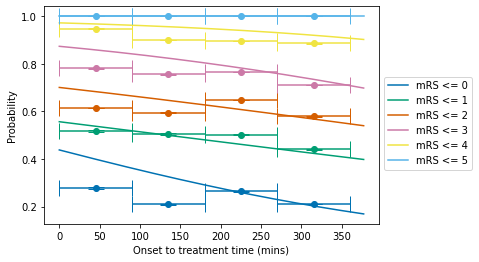

In [40]:
t = np.arange(0,6.3*60)
    
plot_mRS5=1
if plot_mRS5>0:
    A_oly_plot = np.append(A_oly,[0.0])
    
for i,A_i in enumerate(A_oly_plot):
    if i<5:
        p_i = np.exp(A_i + b_oly[i]*t)/(1+np.exp(A_i + b_oly[i]*t))
    else:
        p_i = [1.0 for x in t]
    l,=plt.plot(t, p_i, '-', label = f'mRS <= {i}')
    colour = l.get_color()
    
    # Scatter the treated patient population at the given times (Lees+2010):
    plt.errorbar(nts,bns[i,:],yerr=ens[i,:],xerr=45,fmt='o',color=colour,capsize=8)
     
plt.legend(loc='upper left', bbox_to_anchor=[1.0,0.5,0.2,0.2])

plt.ylabel('Probability')

plt.xlabel('Onset to treatment time (mins)')

plt.show()

### Plot some of the factors used to calculate `bins_0_oly`.

Make plots to show the 'Gap A' and 'Gap B' mentioned in `get_dist_0()`

Define a new $p_3 = P(mRS<=1 | t=0)$ to make labelling clearer.

In [41]:
def plot_thromb_probs(dist_0, dist_F, bins_0, bins_F, T0=8*60, 
                      mark_data_ect=0,mark_data_oly=0,colour_bins=0,  
                      extra_arrows=1, b02=0.0, b0m=0.0, labels_e=[]):
    """
    Probability lines plot with annotated arrows for key areas.
    
    Inputs:
    dist_0       - List or np.array. Probabilities of each mRS at a given time t.
    title        - Str. Title for axis, and determines whether to do certain actions
                   for 'thrombectomy' or 'thrombolysis'.
    T0           - Float or int. Time of non-effect.
    colour_bins  - int, 0 or 1. Set to 1 to fill the gaps between the lines.
    extra_arrows - int, 0 or 1. Set to 1 to draw vertical arrows between b02 and b0m.
    b02          - Float. One of the t=0 bin values for extra arrows.
    b0m          - Float. One of the t=0 bin values for extra arrows.
    labels_e     - List or np.array. Labels for the extra arrows.
    """
    # Time range:
    t = np.arange(0,T0)

    # Calculate a, b, A again as before:
    F = np.cumsum(dist_F)
    F = F/F[-1]

    p1 = np.log(np.cumsum(dist_0)[:-1])
    p2 = np.log(1 - np.cumsum(dist_0)[:-1])
    p3 = np.log(F[:-1])
    p4 = np.log(1 - F[:-1])
    #
    a = p1-p2 - p3+p4
    A = a+p3-p4
    b = -a/(T0)

    plt.figure(figsize=(10,5))
    plot_probs(A,b,t,bins_0,bins_F,colour_bins,mark_data_ect,mark_data_oly)


    # Extra annotations:
    # Vertical line for times 0, T0:
    for T in [0,T0]:
        plt.axvline(T, color='Gainsboro', zorder=0)

    if extra_arrows>0:
        # Arrow style dictionary:
        adict = dict(color='k', arrowstyle='<|-|>')
        # Plot arrow then label
        # Gap B:
        plt.annotate('', xy=(-20,b02), xytext=(-20,1), arrowprops=adict)
        plt.annotate(labels_e['gapb1'], xy=(-60,np.mean([1.0,b02])),
                     va='center', ha='center')
        # p5 line:
        plt.annotate('', xy=(-20,b02), xytext=(-20,0), arrowprops=adict)
        plt.annotate(labels_e['p1'], xy=(-60, np.mean([0.0,b02])),
                     va='center', ha='center')
        # Gap A:
        plt.annotate('', xy=(-35,b02), xytext=(-35,b0m), arrowprops=adict)
        plt.annotate(labels_e['gapa1'], xy=(-70,np.mean([b02,b0m])),
                     va='center', ha='center')
        
    # Figure setup:        
    plt.xlim(-99,550)
    

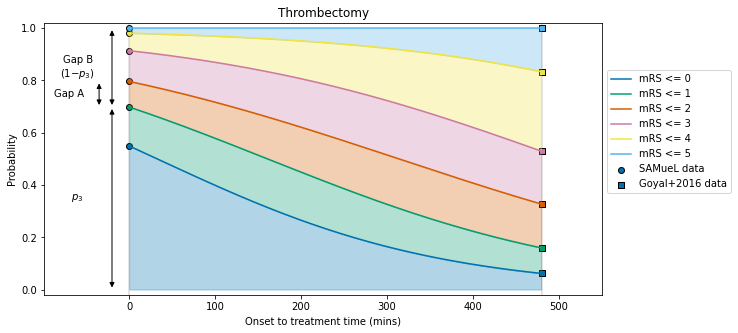

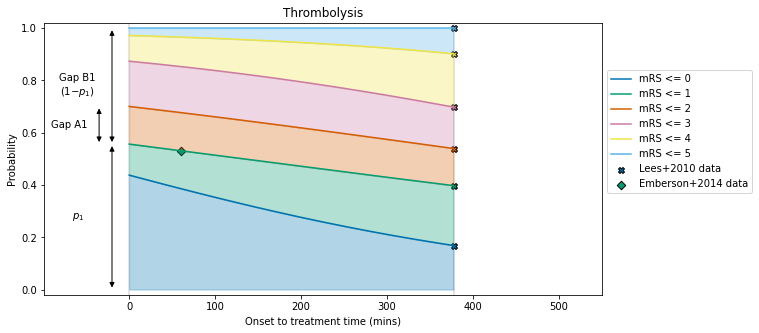

              Gap A(1) | Gap B(1) | Ratio
Thrombectomy:  0.0981  |  0.3015  | 0.3253
Thrombolysis:  0.1442  |  0.4433  | 0.3253


In [42]:
# Plot the two probability distributions:
m_test = 2

# Thrombectomy:
b02_ect = bins_0[2]
b0m_ect = bins_0[m_test+1]
labels_ect = {'gapb1':'Gap B\n'+r'(1$-p_3$)',
              'gapa1':'Gap A',
              'p1':r'$p_3$'}
plot_thromb_probs(dist_0, dist_F_ect, bins_0, bins_F_ect, 
                  T0=8*60, colour_bins=1, mark_data_ect=1,
                  extra_arrows=1, b02=b02_ect, b0m=b0m_ect, labels_e=labels_ect)
plt.title('Thrombectomy')
plt.show()


# Thrombolysis:
b02_oly = bins_0_oly[2]
b0m_oly = bins_0_oly[m_test+1]
labels_oly = {'gapb1':'Gap B1\n'+r'(1$-p_1$)',
              'gapa1':'Gap A1',
              'p1':r'$p_1$'}
plot_thromb_probs(dist_0_oly, dist_F_oly, bins_0_oly, bins_F_oly,
                  T0=6.3*60, colour_bins=1, mark_data_oly=1,
                  extra_arrows=1, b02=b02_oly, b0m=b0m_oly, labels_e=labels_oly)
plt.title('Thrombolysis')
plt.show()


# Also print the ratios of Gap A to Gap B:
gapA   = b0m_ect - b02_ect
gapB   = 1.0  - b02_ect
ratAB  = gapA / gapB

gapA1  = b0m_oly - b02_oly
gapB1  = 1.0   - b02_oly
ratAB1 = gapA1 / gapB1

print('              Gap A(1) | Gap B(1) | Ratio')
print(f'Thrombectomy:  {gapA:1.4f}  |  {gapB:1.4f}  | {ratAB:1.4f}')
print(f'Thrombolysis:  {gapA1:1.4f}  |  {gapB1:1.4f}  | {ratAB1:1.4f}')

### Get errors from Emberson's CI, assuming log odds = 0 at T_0

Calculate a new distribution at time=0 using the known $\pm$ values on the odds ratio at time T=1hr for mRS$\leq$1. OR was 1.9. 

Then follow this through to each of the other mRS distributions - use the scaling of the high and low t=0 mRS$\leq$1 points in the same way as before.

In [43]:
OR_low = 1.4
OR_hi = 2.6
    
d_low,_ = get_dist_0(dist_F_oly,dist_0,OR_low)

d_hi,_ = get_dist_0(dist_F_oly,dist_0,OR_hi)
    
    

#### Lower limit 

In [44]:
p1 = np.log(np.cumsum(d_low)[:-1])
p2 = np.log(1 - np.cumsum(d_low)[:-1])
p3 = np.log(F_oly[:-1])
p4 = np.log(1 - F_oly[:-1])

a_low = p1-p2 - p3+p4

In [45]:
b_low = -a_low/(6.3*60)

In [46]:
A_low = a_low+p3-p4

#### Upper limit 

In [47]:
p1 = np.log(np.cumsum(d_hi)[:-1])
p2 = np.log(1 - np.cumsum(d_hi)[:-1])
p3 = np.log(F_oly[:-1])
p4 = np.log(1 - F_oly[:-1])

a_hi = p1-p2 - p3+p4

In [48]:
b_hi = -a_hi/(6.3*60)

In [49]:
A_hi = a_hi+p3-p4

### Plot P as function of time 

n.b. no errors for mRS=5yet so just plotted the base line:

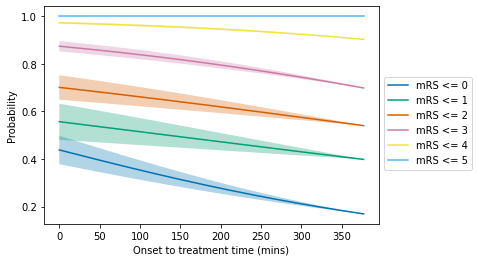

In [50]:
t = np.arange(0,6.3*60)

for i,A_i in enumerate(A_oly):
    
    p_i   = np.exp(A_i      + b_oly[i]*t) / (1+np.exp(A_i      + b_oly[i]*t))
    p_low = np.exp(A_low[i] + b_low[i]*t) / (1+np.exp(A_low[i] + b_low[i]*t))
    p_hi  = np.exp(A_hi[i]  + b_hi[i]*t ) / (1+np.exp(A_hi[i]  + b_hi[i]*t) )
    
    plt.plot(t, p_i, '-', label = f'mRS <= {i}')
    
    plt.fill_between(t, p_low, p_hi, alpha=0.3)

    
plt.plot(t, [1.0 for x in t], '-', label = 'mRS <= 5')

plt.legend(loc='best',bbox_to_anchor=[1.0,0.5,0.2,0.2])

plt.ylabel('Probability')

plt.xlabel('Onset to treatment time (mins)')

plt.show()